# Sales volume time series with ARIMA

Guess Mercadona wants to know the Sales volume for the next 30 days, and also wants to compare the sales with two competitor supermarkets.

Dates: From March 6th, 2021 to November 30th,2022.
website: https://datamarket.es/dashboards?slug=productos-de-supermercados

Dataset information:
3 online supermarkets in Spain: Dia, Carrefour, Mercadona


Features:
category: Categoría del producto.
description: Información adicional del producto (formato de empaquetado, etc.).
insert_date: Fecha de extracción de la información.
name: Nombre del producto.
price: Precio absoluto del producto en €. En caso de existir algún tipo de descuento aparecerá el menor precio disponible.
reference_price: Precio unitario (por unidad de medida del producto, €/Kg, €/L, etc.).
reference_unit: Unidad de referencia del producto (Kg, L, etc.).
supermarket: Supermercado al que pertenece el producto.

# 1. Import libraries and understand the data

In [141]:
#Exploring data
import pandas as pd
import numpy as np
from datetime import timedelta
from collections import Counter

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline


In [142]:
raw_data = pd.read_csv(r"./data:raw/datamarket_supermercados.csv", encoding="UTF8")
raw_data.tail()

,url,supermarket,category,name,description,price,reference_price,reference_unit,insert_date,product_id
9258602,https://www.dia.es/compra-online/bebidas/refre...,dia-es,bebidas_refrescos,COCA-COLA zero lata 33 cl,NaN,0.82,2.480,l,2022-12-01 00:00:00,a5a3b7c2045cbbc2afe847c4e1740615
9258603,https://tienda.mercadona.es/product/4919/secre...,mercadona-es,carne_cerdo,Secreto de cerdo ibérico,Bandeja,5.93,23.700,kg,2022-12-01 00:00:00,8ed31ae2560067cd9399e780d0cb0853
9258604,https://www.dia.es/compra-online/frescos/carne...,dia-es,frescos_carne_cerdo,Lomo adobado al horno bandeja 330 gr,NaN,3.09,9.360,kg,2022-12-01 00:00:00,f4dbd561ff7be8fc1ab1fb9e659fab4f
9258605,https://tienda.mercadona.es/product/69297/ajos...,mercadona-es,fruta_y_verdura_verdura,Ajos morados,Malla,1.45,5.800,kg,2022-12-01 00:00:00,fd8b87c9d8cd9c6c80cad59278ee37f3
9258606,https://tienda.mercadona.es/product/69079/cebo...,mercadona-es,fruta_y_verdura_verdura,Cebollas,Malla,2.49,1.245,kg,2022-12-01 00:00:00,e3da1a39617b941c50ffb47fd20391e9


,url,supermarket,category,name,description,price,reference_price,reference_unit,insert_date,product_id
9258602,https://www.dia.es/compra-online/bebidas/refre...,dia-es,bebidas_refrescos,COCA-COLA zero lata 33 cl,NaN,0.82,2.480,l,2022-12-01 00:00:00,a5a3b7c2045cbbc2afe847c4e1740615
9258603,https://tienda.mercadona.es/product/4919/secre...,mercadona-es,carne_cerdo,Secreto de cerdo ibérico,Bandeja,5.93,23.700,kg,2022-12-01 00:00:00,8ed31ae2560067cd9399e780d0cb0853
9258604,https://www.dia.es/compra-online/frescos/carne...,dia-es,frescos_carne_cerdo,Lomo adobado al horno bandeja 330 gr,NaN,3.09,9.360,kg,2022-12-01 00:00:00,f4dbd561ff7be8fc1ab1fb9e659fab4f
9258605,https://tienda.mercadona.es/product/69297/ajos...,mercadona-es,fruta_y_verdura_verdura,Ajos morados,Malla,1.45,5.800,kg,2022-12-01 00:00:00,fd8b87c9d8cd9c6c80cad59278ee37f3
9258606,https://tienda.mercadona.es/product/69079/cebo...,mercadona-es,fruta_y_verdura_verdura,Cebollas,Malla,2.49,1.245,kg,2022-12-01 00:00:00,e3da1a39617b941c50ffb47fd20391e9


In [143]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9258607 entries, 0 to 9258606
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   url              object 
 1   supermarket      object 
 2   category         object 
 3   name             object 
 4   description      object 
 5   price            float64
 6   reference_price  float64
 7   reference_unit   object 
 8   insert_date      object 
 9   product_id       object 
dtypes: float64(2), object(8)
memory usage: 706.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9258607 entries, 0 to 9258606
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   url              object 
 1   supermarket      object 
 2   category         object 
 3   name             object 
 4   description      object 
 5   price            float64
 6   reference_price  float64
 7   reference_unit   object 
 8   insert_date      object 
 9   product_id       object 


### Digging into the data

This model only needs price and number of products, some features or columns will be removed

In [144]:
#nan on price will be filled consequently if needed
raw_data.isnull().sum()

url                      0
supermarket              0
category                 0
name                   252
description        5867525
price                   18
reference_price          6
reference_unit        5480
insert_date              0
product_id               0
dtype: int64

url                      0
supermarket              0
category                 0
name                   252
description        5867525
price                   18
reference_price          6
reference_unit        5480
insert_date              0
product_id               0
dtype: int64

In [145]:
raw_data[raw_data['price'].isnull()]

,url,supermarket,category,name,description,price,reference_price,reference_unit,insert_date,product_id
6369456,https://www.carrefour.es/supermercado/limon-a-...,carrefour-es,productos_frescos_frutas_naranjas_y_otros_citr...,Limón a granel 1 Kg aprox,NaN,NaN,2.29,kg,2022-05-06 00:00:00,21db945fe921f68bc2fc6940a7372d19
7097432,https://www.dia.es/compra-online/despensa/past...,dia-es,despensa_pastas_harinas_y_masas_pastas,DIA SELECCIÓN MUNDIAL tortiglioni paquete 500 gr,NaN,NaN,NaN,NaN,2022-06-27 00:00:00,61a283804a2289fbe661250c83c1a717
7099540,https://www.dia.es/compra-online/despensa/lact...,dia-es,despensa_lacteos_y_huevos_mantequilla_y_margarina,DIA margarina ligera barqueta 500 gr,NaN,NaN,NaN,NaN,2022-06-27 00:00:00,65f083cea3dd8750f4738e187ec0dbc4
7099979,https://www.dia.es/compra-online/despensa/desa...,dia-es,despensa_desayunos_y_dulces_bolleria,BISCUITS GALICIA mini magdalenas con mantequil...,NaN,NaN,NaN,NaN,2022-06-27 00:00:00,d522a411cc1cc234dd353d4f14380733
7111858,https://www.dia.es/compra-online/despensa/desa...,dia-es,despensa_desayunos_y_dulces_bolleria,BISCUITS GALICIA mini magdalenas con mantequil...,NaN,NaN,NaN,NaN,2022-06-28 00:00:00,d522a411cc1cc234dd353d4f14380733
7123873,https://www.dia.es/compra-online/despensa/lact...,dia-es,despensa_lacteos_y_huevos_mantequilla_y_margarina,DIA margarina ligera barqueta 500 gr,NaN,NaN,NaN,NaN,2022-06-28 00:00:00,65f083cea3dd8750f4738e187ec0dbc4
7124313,https://www.dia.es/compra-online/despensa/past...,dia-es,despensa_pastas_harinas_y_masas_pastas,DIA SELECCIÓN MUNDIAL tortiglioni paquete 500 gr,NaN,NaN,NaN,NaN,2022-06-28 00:00:00,61a283804a2289fbe661250c83c1a717
7273682,https://www.carrefour.es/supermercado/ginebra-...,carrefour-es,bebidas_alcoholes_ginebra,Ginebra Gordon's 1 l.,NaN,NaN,13.49,l,2022-07-09 00:00:00,4dfc046c75551b4d2324070e00ae2a49
7385791,https://www.carrefour.es/supermercado/whisky-j...,carrefour-es,bebidas_alcoholes_todos_los_alcoholes,Whisky Jameson irlandés 70 cl.,NaN,NaN,25.99,l,2022-07-17 00:00:00,c09040febafa3b18253fa796df590548
7399956,https://www.carrefour.es/supermercado/whisky-j...,carrefour-es,bebidas_alcoholes_todos_los_alcoholes,Whisky Jameson irlandés 70 cl.,NaN,NaN,25.99,l,2022-07-18 00:00:00,c09040febafa3b18253fa796df590548


,url,supermarket,category,name,description,price,reference_price,reference_unit,insert_date,product_id
6369456,https://www.carrefour.es/supermercado/limon-a-...,carrefour-es,productos_frescos_frutas_naranjas_y_otros_citr...,Limón a granel 1 Kg aprox,NaN,NaN,2.29,kg,2022-05-06 00:00:00,21db945fe921f68bc2fc6940a7372d19
7097432,https://www.dia.es/compra-online/despensa/past...,dia-es,despensa_pastas_harinas_y_masas_pastas,DIA SELECCIÓN MUNDIAL tortiglioni paquete 500 gr,NaN,NaN,NaN,NaN,2022-06-27 00:00:00,61a283804a2289fbe661250c83c1a717
7099540,https://www.dia.es/compra-online/despensa/lact...,dia-es,despensa_lacteos_y_huevos_mantequilla_y_margarina,DIA margarina ligera barqueta 500 gr,NaN,NaN,NaN,NaN,2022-06-27 00:00:00,65f083cea3dd8750f4738e187ec0dbc4
7099979,https://www.dia.es/compra-online/despensa/desa...,dia-es,despensa_desayunos_y_dulces_bolleria,BISCUITS GALICIA mini magdalenas con mantequil...,NaN,NaN,NaN,NaN,2022-06-27 00:00:00,d522a411cc1cc234dd353d4f14380733
7111858,https://www.dia.es/compra-online/despensa/desa...,dia-es,despensa_desayunos_y_dulces_bolleria,BISCUITS GALICIA mini magdalenas con mantequil...,NaN,NaN,NaN,NaN,2022-06-28 00:00:00,d522a411cc1cc234dd353d4f14380733
7123873,https://www.dia.es/compra-online/despensa/lact...,dia-es,despensa_lacteos_y_huevos_mantequilla_y_margarina,DIA margarina ligera barqueta 500 gr,NaN,NaN,NaN,NaN,2022-06-28 00:00:00,65f083cea3dd8750f4738e187ec0dbc4
7124313,https://www.dia.es/compra-online/despensa/past...,dia-es,despensa_pastas_harinas_y_masas_pastas,DIA SELECCIÓN MUNDIAL tortiglioni paquete 500 gr,NaN,NaN,NaN,NaN,2022-06-28 00:00:00,61a283804a2289fbe661250c83c1a717
7273682,https://www.carrefour.es/supermercado/ginebra-...,carrefour-es,bebidas_alcoholes_ginebra,Ginebra Gordon's 1 l.,NaN,NaN,13.49,l,2022-07-09 00:00:00,4dfc046c75551b4d2324070e00ae2a49
7385791,https://www.carrefour.es/supermercado/whisky-j...,carrefour-es,bebidas_alcoholes_todos_los_alcoholes,Whisky Jameson irlandés 70 cl.,NaN,NaN,25.99,l,2022-07-17 00:00:00,c09040febafa3b18253fa796df590548
7399956,https://www.carrefour.es/supermercado/whisky-j...,carrefour-es,bebidas_alcoholes_todos_los_alcoholes,Whisky Jameson irlandés 70 cl.,NaN,NaN,25.99,l,2022-07-18 00:00:00,c09040febafa3b18253fa796df590548


In [146]:
#outliers? , it seems max is 7999, check it, it may be an error or an outlier
raw_data.describe()

,price,reference_price
count,9.258589e+06,9.258601e+06
mean,4.767783e+00,1.875591e+01
std,4.819318e+01,5.961314e+02
min,8.000000e-02,3.000000e-03
25%,1.390000e+00,1.834000e+00
50%,2.250000e+00,4.600000e+00
75%,3.990000e+00,9.950000e+00
max,7.915050e+03,1.633333e+05


,price,reference_price
count,9.258589e+06,9.258601e+06
mean,4.767783e+00,1.875591e+01
std,4.819318e+01,5.961314e+02
min,8.000000e-02,3.000000e-03
25%,1.390000e+00,1.834000e+00
50%,2.250000e+00,4.600000e+00
75%,3.990000e+00,9.950000e+00
max,7.915050e+03,1.633333e+05


Deal with outliers

In [147]:
# the most expensive fruit or veggie cost 7€, just in case, it is set in 8. It seems everything is multiplied by 100!! and only in mercadona supermarket!.
raw_data['price'] = np.where((raw_data['price'] >= 490.05) &
                             (raw_data['supermarket']=='mercadona-es') |
                             ((raw_data['category'] == 'fruta_y_verdura_verdura') & (raw_data['price']>= 8.0)) |
                             ((raw_data['category'] == 'fruta_y_verdura_fruta') & (raw_data['price']>= 8.0)),
                             round(raw_data['price']/100,2), raw_data['price'].values)

#raw_data.sort_values(by='price')

In [148]:
raw_data['insert_date'] = pd.to_datetime(raw_data['insert_date']).dt.normalize()

#insert_date is the date of the day after the sale
raw_data['daily_sales'] = raw_data['insert_date']- timedelta(days=1)

raw_data['unit']= int(1)

In [149]:
raw_data = raw_data.drop(['url', 'category', 'description', 'reference_price', 'reference_unit', 'insert_date', 'product_id'], axis=1)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9258607 entries, 0 to 9258606
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   supermarket  object        
 1   name         object        
 2   price        float64       
 3   daily_sales  datetime64[ns]
 4   unit         int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 353.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9258607 entries, 0 to 9258606
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   supermarket  object        
 1   name         object        
 2   price        float64       
 3   daily_sales  datetime64[ns]
 4   unit         int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 353.2+ MB


# 2. Compare sales among the supermarkets

Split data of the different supermarkets

In [150]:
raw_data_carre = raw_data[raw_data['supermarket']=='carrefour-es']
raw_data_dia = raw_data[raw_data['supermarket']=='dia-es']
raw_data_merca = raw_data[raw_data['supermarket']=='mercadona-es']

In [151]:
raw_data_carre = raw_data_carre.drop(['supermarket'], axis=1)
raw_data_dia = raw_data_dia.drop(['supermarket'], axis=1)
raw_data_merca = raw_data_merca.drop(['supermarket'], axis=1)


In [152]:
# Make copies for the modeling
rmodelCarre= raw_data_carre.copy()
rmodelDia = raw_data_dia.copy()
rmodelMerca = raw_data_merca.copy()

In [153]:
# Number of products and total sales
print("Carrefour's number of products sold: ", raw_data_carre.shape[0], ", total sales(€): ","",round(raw_data_carre['price'].sum(),2))
print("Dia's number of products sold: ", raw_data_dia.shape[0], ", \ttotal sales(€): ",round(raw_data_dia['price'].sum(),2))
print("Mercadona's number of products sold: ", raw_data_merca.shape[0], ", total sales(€): ",round(raw_data_merca['price'].sum(),2))

#Carrefour vs Mercadona vs Dia volumen
print("\nDifference on number of products between Mercadona and Carrefour: ", raw_data_merca.shape[0] - raw_data_carre.shape[0])
print("Difference on number of products between Mercadona and Dia: ", raw_data_merca.shape[0] - raw_data_dia.shape[0])
print("Difference on total sales between Mercadona and Carrefour(€): ", round(raw_data_merca['price'].sum() - raw_data_carre['price'].sum(),2))
print("Difference on total sales between Mercadona and Dia(€): ", round(raw_data_merca['price'].sum() - raw_data_dia['price'].sum(),2))
#Dia earns more than Mercadona

Carrefour's number of products sold:  1911385 , total sales(€):   9705187.62
Dia's number of products sold:  3607840 , 	total sales(€):  12289918.39
Mercadona's number of products sold:  3739382 , total sales(€):  12165224.9

Difference on number of products between Mercadona and Carrefour:  1827997
Difference on number of products between Mercadona and Dia:  131542
Difference on total sales between Mercadona and Carrefour(€):  2460037.28
Difference on total sales between Mercadona and Dia(€):  -124693.49
Carrefour's number of products sold:  1911385 , total sales(€):   9705187.62
Dia's number of products sold:  3607840 , 	total sales(€):  12289918.39
Mercadona's number of products sold:  3739382 , total sales(€):  12165224.9

Difference on number of products between Mercadona and Carrefour:  1827997
Difference on number of products between Mercadona and Dia:  131542
Difference on total sales between Mercadona and Carrefour(€):  2460037.28
Difference on total sales between Mercadona an

### Check out the most expensive products by supermarket

In [154]:
raw_data_carre_expensive= raw_data_carre.groupby('name').sum()
rd_carre_expensive = raw_data_carre_expensive.sort_values('price', ascending=False)[:5]

raw_data_dia_expensive= raw_data_dia.groupby('name').sum()
rd_dia_expensive = raw_data_dia_expensive.sort_values('price', ascending=False)[:5]

raw_data_merca_expensive= raw_data_merca.groupby('name').sum()
rd_merca_expensive = raw_data_merca_expensive.sort_values('price', ascending=False)[:5]

print("Carrefour most expensive products: \n", rd_carre_expensive, end="\n\n")
print("\nDia most expensive products: \n", rd_dia_expensive, end="\n\n")
print("\nMercadona most expensive products: \n", rd_merca_expensive)

Carrefour most expensive products: 
                                                       price  unit
name                                                             
Jamón de cebo ibérico 50% raza ibérica Legado I...  70161.0   533
Jamón de bellota ibérico 100% raza ibérica piez...  54032.0   148
Jamón curado reserva 4 estaciones Navidul pieza...  37216.0   568
Paleta de bellota ibérica 100% raza ibérica pie...  36232.0   178
Jamón de cebo ibérico 50% raza ibérica pieza de...  32755.0   286


Dia most expensive products: 
                                                       price  unit
name                                                             
NOBLEZA EXTREMEÑA jamón de bellota 100% ibérico...  69071.0   239
LEGADO jamón de cebo Ibérico 50% raza ibérica p...  65274.0   542
SÁNCHEZ ALCARAZ jamón de cebo Ibérico 50% pieza...  62150.8   552
CANPIPORK jamón de cebo Ibérico 50% raza ibéric...  44689.0   411
MANUEL DE MONTEJO jamón de cebo Ibérico 50% pie...  40593.0   367


Merc

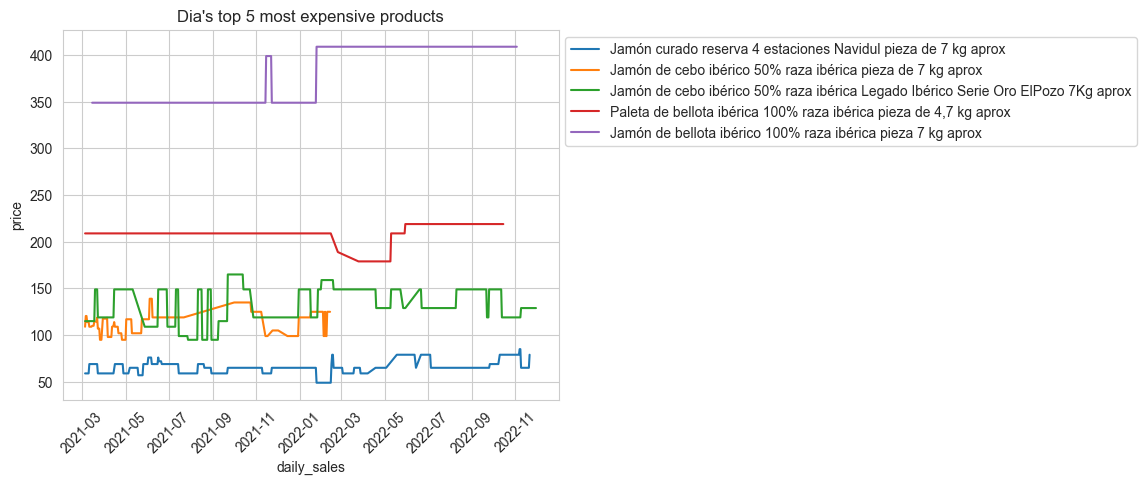

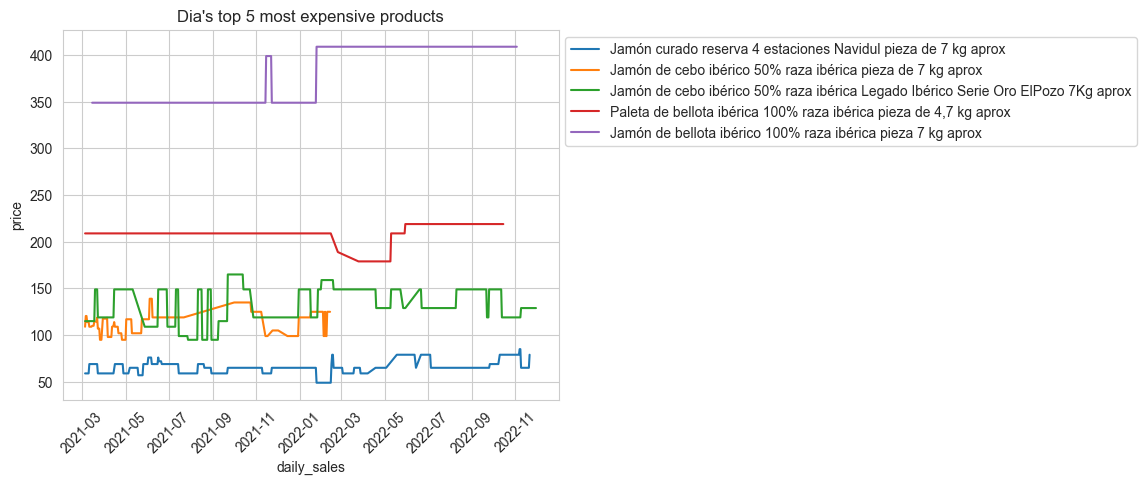

In [155]:
#Top 5 most expensive items
los5ExCarre= list(rd_carre_expensive.index)
Carre5Ex = pd.DataFrame(raw_data_carre[raw_data_carre.name.isin(los5ExCarre)])
Carre5Ex['price'].dropna()
Carre5Ex=Carre5Ex.loc[:,['daily_sales', 'name', 'price', 'unit']]

#Visualization
sns.set_style('whitegrid')
ax = sns.lineplot(data= Carre5Ex, x='daily_sales',
             y ='price', hue='name', err_style=None)
legend = plt.legend(fontsize = '9')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Dia's top 5 most expensive products")
plt.xticks(rotation=45)
plt.show();




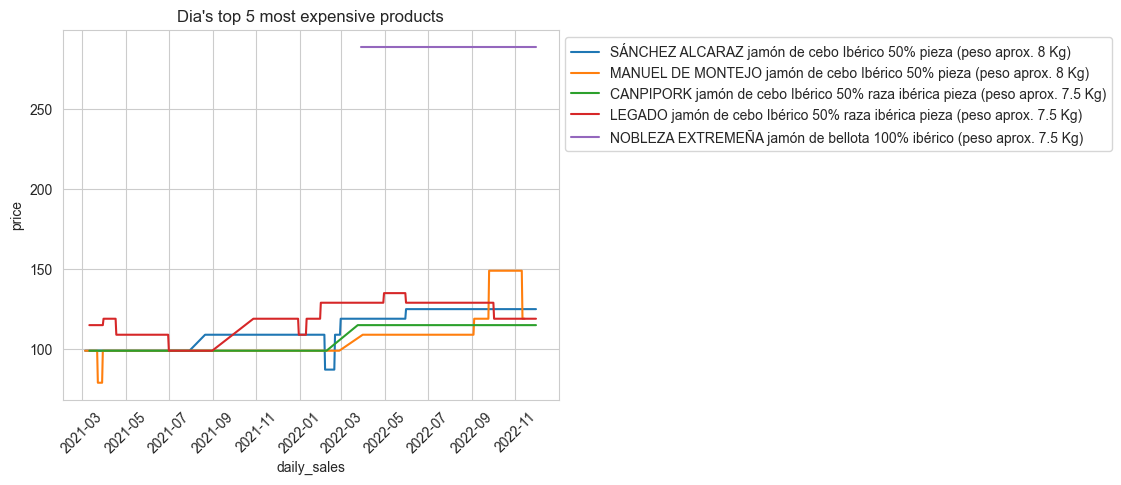

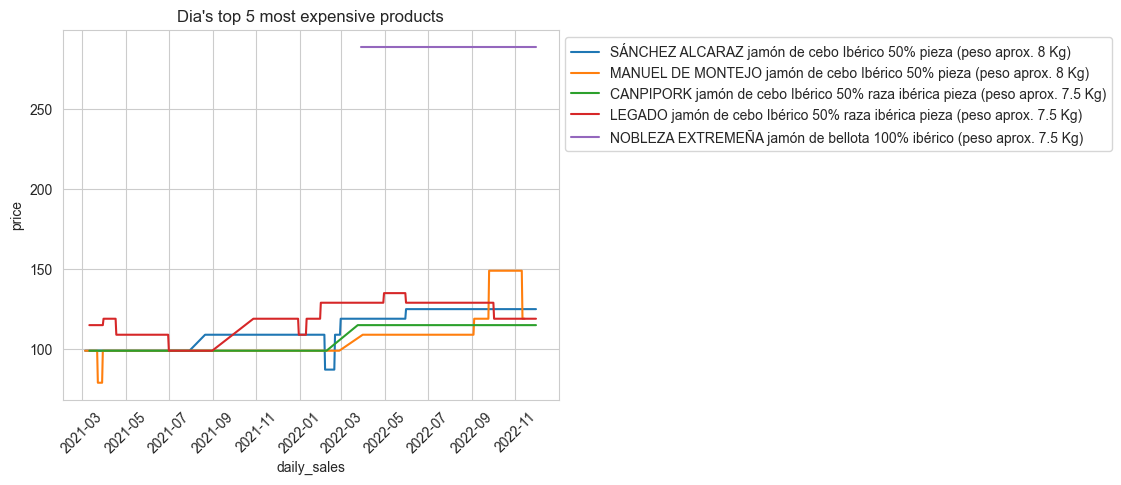

In [156]:
los5ExDia= list(rd_dia_expensive.index)
Dia5Ex = pd.DataFrame(raw_data_dia[raw_data_dia.name.isin(los5ExDia)])
Dia5Ex['price'].dropna()
Dia5Ex=Dia5Ex.loc[:,['daily_sales', 'name', 'price', 'unit']]

#Visualization
sns.set_style('whitegrid')
ax = sns.lineplot(data= Dia5Ex, x='daily_sales',
             y ='price', hue='name', err_style=None)
legend = plt.legend(fontsize = '9')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Dia's top 5 most expensive products")
plt.xticks(rotation=45)
plt.show();

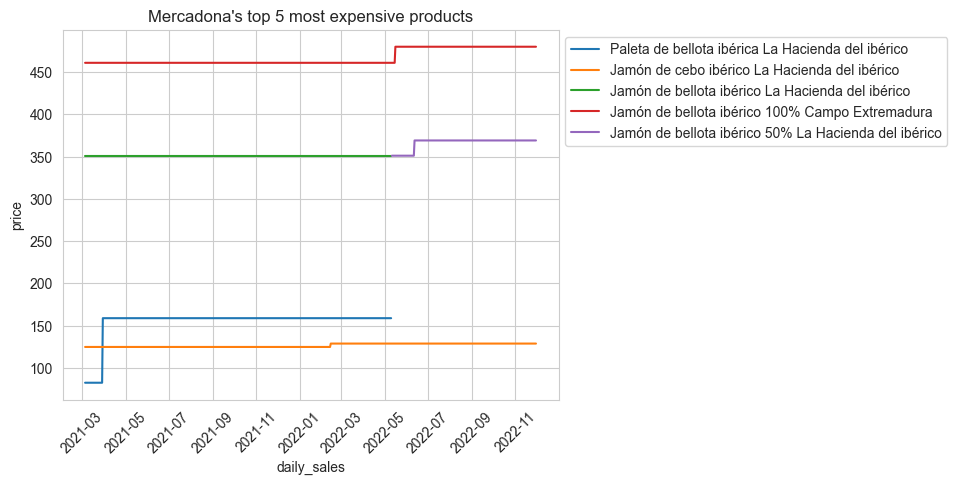

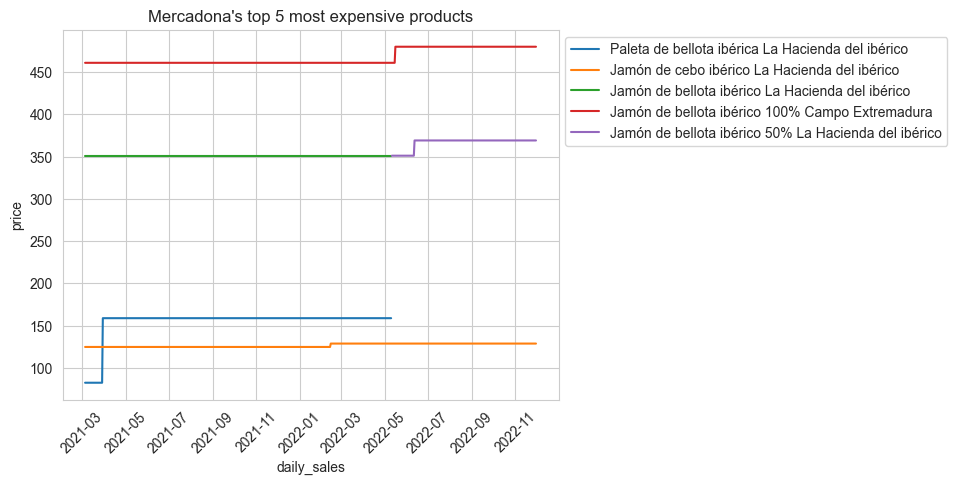

In [157]:
los5ExMerca= list(rd_merca_expensive.index)
Merca5Ex = pd.DataFrame(raw_data_merca[raw_data_merca.name.isin(los5ExMerca)])
Merca5Ex=Merca5Ex.loc[:,['daily_sales', 'name', 'price', 'unit']]

#Visualization
sns.set_style('whitegrid')
ax = sns.lineplot(data= Merca5Ex, x='daily_sales',
             y ='price', hue='name', err_style=None)
legend = plt.legend(fontsize = '9')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Mercadona's top 5 most expensive products")
plt.xticks(rotation=45)
plt.show();

### Check out the most sold products

In [158]:
#count the 5 products most bought among all supermarkets
prod_most_commonCarre5 = Counter(raw_data_carre['name']).most_common(5)
prod_most_commonDia5 = Counter(raw_data_dia['name']).most_common(5)
prod_most_commonMerca5 = Counter(raw_data_merca['name']).most_common(5)

most_commonCarre5 = pd.DataFrame(prod_most_commonCarre5, columns= ['Carrefour most sold', 'Units'])
most_commonDia5 = pd.DataFrame(prod_most_commonDia5, columns= ['Dia most sold', 'Units'])
most_commonMerca5 = pd.DataFrame(prod_most_commonMerca5, columns= ['Mercadona Most sold', 'Units'])
print(most_commonCarre5, most_commonDia5, most_commonMerca5, sep='\n\n')

                                 Carrefour most sold  Units
0                              Vodka Vikoroff 70 cl.   1014
1            Conos con helado de nata Cornetto 6 ud.    900
2              Bombilla Led Estándar Philips 60W E27    807
3  Crema fijadora para prótesis dentales Corega 7...    737
4             Bálsamo labial hidratante Carmex 1 ud.    729

                                       Dia most sold  Units
0  INSTITUTO ESPAÑOL agua de colonia gotas fresca...   1262
1      SANEX desodorante natur protect roll on 50 ml   1149
2       SANEX desodorante natur protect spray 200 ml   1047
3             DIA cocktail frutos secos bolsa 500 gr    817
4          BONTE desodorante attraction spray 150 ml    761

              Mercadona Most sold  Units
0       Cerveza Clásica Steinburg   5691
1              Refresco Coca-Cola   4452
2  Refresco Coca-Cola Zero azúcar   4315
3      Cerveza Especial Steinburg   4151
4         Refresco cola Hacendado   3180
                                

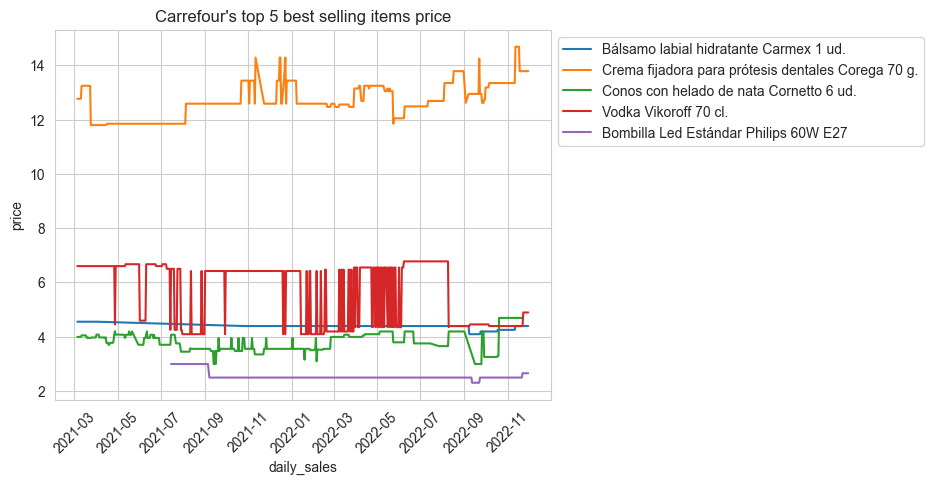

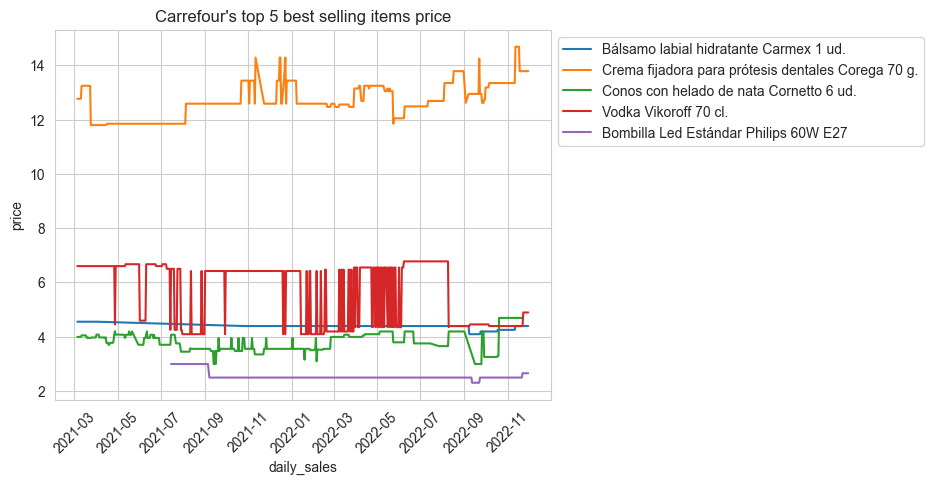

In [159]:
#Top 5 best selling items
los5C= list(most_commonCarre5.iloc[:,0])
Carre5 = pd.DataFrame(raw_data_carre[raw_data_carre.name.isin(los5C)])
Carre5['price'].dropna()
Carre5=Carre5.loc[:,['daily_sales', 'name', 'price', 'unit']]

#Visualization
sns.set_style('whitegrid')
ax = sns.lineplot(data= Carre5, x='daily_sales',
             y ='price', hue='name', err_style=None)
legend = plt.legend(fontsize = '9')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Carrefour's top 5 best selling items price")
plt.xticks(rotation=45)
plt.show();

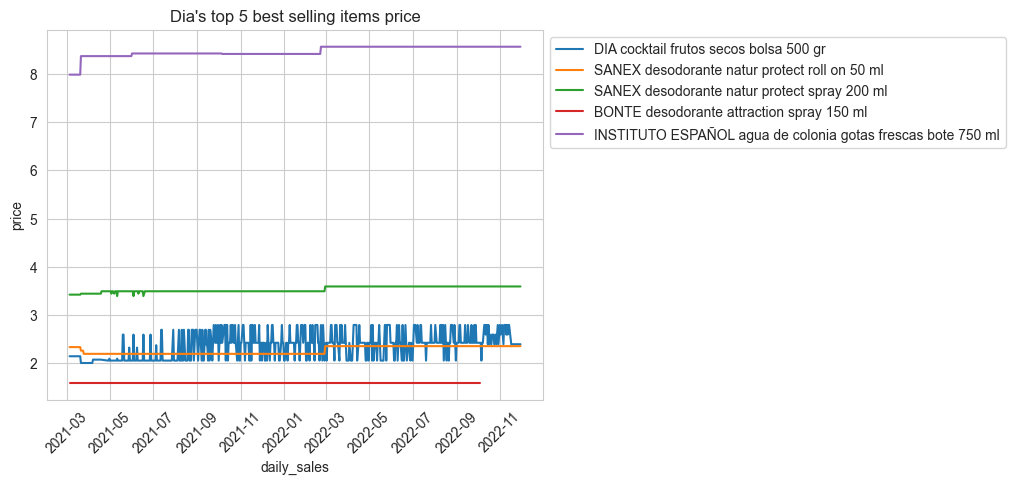

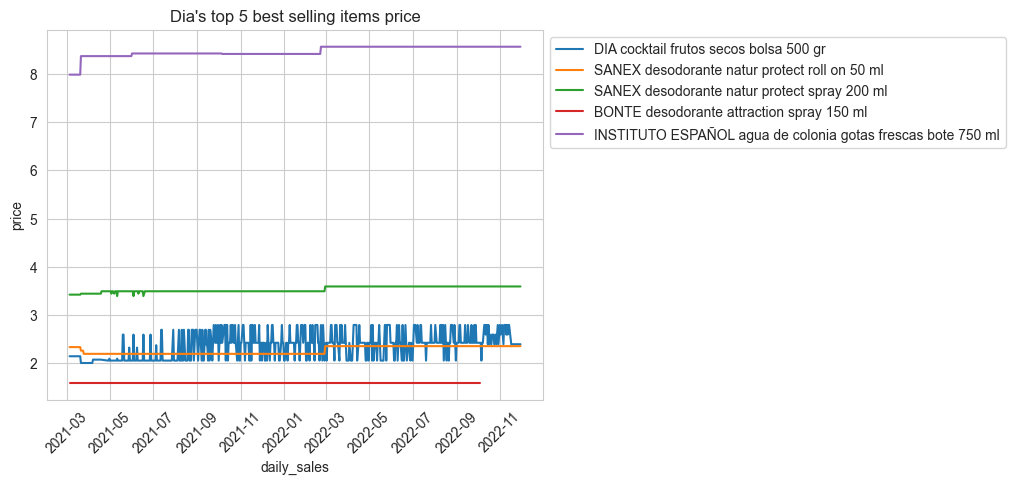

In [160]:
#Top 5 best selling items
los5D= list(most_commonDia5.iloc[:,0])
Dia5 = pd.DataFrame(raw_data_dia[raw_data_dia.name.isin(los5D)])
Dia5['price'].dropna()
Dia5=Dia5.loc[:,['daily_sales', 'name', 'price', 'unit']]

#Visualization
sns.set_style('whitegrid')
ax = sns.lineplot(data= Dia5, x='daily_sales',
             y ='price', hue='name', err_style=None)
legend = plt.legend(fontsize = '9')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Dia's top 5 best selling items price")
plt.xticks(rotation=45)
plt.show();

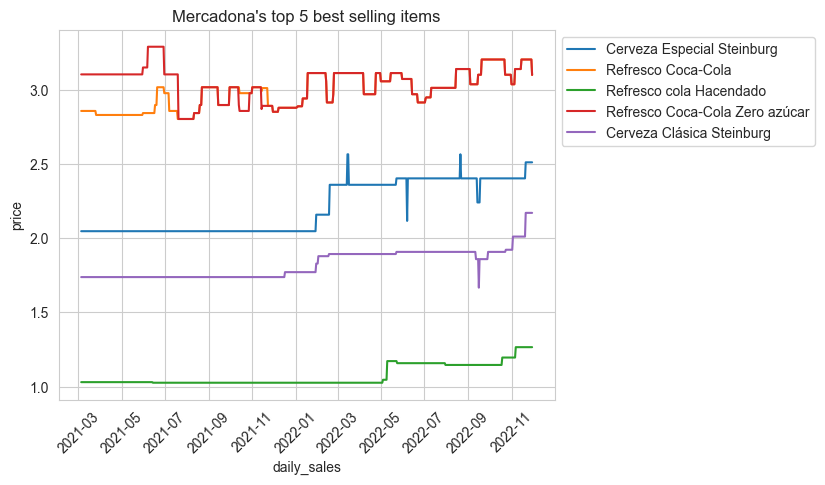

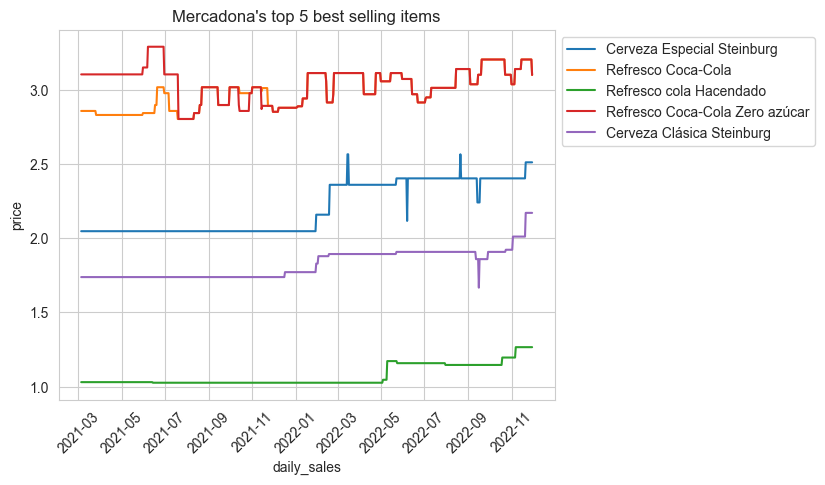

In [161]:
los5M= list(most_commonMerca5.iloc[:,0])
Merca5 = pd.DataFrame(raw_data_merca[raw_data_merca.name.isin(los5M)])
Merca5['price'].dropna()
Merca5=Merca5.loc[:,['daily_sales','name', 'price', 'unit']]
#Visualization
sns.set_style('whitegrid')
ax = sns.lineplot(data= Merca5, x='daily_sales',
             y ='price', hue='name', err_style=None)
legend = plt.legend(fontsize = '9')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Mercadona's top 5 best selling items")
plt.xticks(rotation=45)
plt.show();

### Check out monthly sales evolution of the supermarkets

Carrefour monthly sales evolution

In [162]:
Carre5_oct = Carre5.set_index("daily_sales")
Carre5_oct= Carre5_oct.rename_axis("monthly_sales")

In [163]:
Carre5_oct1= Carre5_oct.groupby([pd.Grouper(freq='M'),'name']).sum()
Carre5_oct1 =Carre5_oct1.rename(columns={'price':'sales'})
Carre5_oct1

sales  unit
monthly_sales name                                                            
2021-03-31    Bálsamo labial hidratante Carmex 1 ud.              222.95    49
              Conos con helado de nata Cornetto 6 ud.             187.78    47
              Crema fijadora para prótesis dentales Corega 70 g.  343.27    27
              Vodka Vikoroff 70 cl.                               356.40    54
2021-04-30    Bálsamo labial hidratante Carmex 1 ud.               18.20     4
...                                                                  ...   ...
2022-11-30    Bombilla Led Estándar Philips 60W E27               144.81    57
              Bálsamo labial hidratante Carmex 1 ud.              251.82    58
              Conos con helado de nata Cornetto 6 ud.              46.90    10
              Crema fijadora para prótesis dentales Corega 70 g.  535.31    39
              Vodka Vikoroff 70 cl.                               131.31    29

[96 rows x 2 columns]

sales  unit
monthly_sales name                                                            
2021-03-31    Bálsamo labial hidratante Carmex 1 ud.              222.95    49
              Conos con helado de nata Cornetto 6 ud.             187.78    47
              Crema fijadora para prótesis dentales Corega 70 g.  343.27    27
              Vodka Vikoroff 70 cl.                               356.40    54
2021-04-30    Bálsamo labial hidratante Carmex 1 ud.               18.20     4
...                                                                  ...   ...
2022-11-30    Bombilla Led Estándar Philips 60W E27               144.81    57
              Bálsamo labial hidratante Carmex 1 ud.              251.82    58
              Conos con helado de nata Cornetto 6 ud.              46.90    10
              Crema fijadora para prótesis dentales Corega 70 g.  535.31    39
              Vodka Vikoroff 70 cl.                               131.31    29

[96 rows x 2 columns]

In [164]:
#M1 one month
df = px.data.stocks()
fig= px.line(Carre5_oct1, x=Carre5_oct1.index.get_level_values(0), y='sales', color=Carre5_oct1.index.get_level_values(1))
fig.update_xaxes(dtick='M1', tickformat = '%b\n%Y')
fig.update_layout(showlegend= True, xaxis_title= None, yaxis_title="Sales (€)",
                  title={
        'text': 'Carrefour monthly sales',
        'y':0.95,
        'x':0.53,
        'xanchor': 'center',
        'yanchor': 'top'},
    legend=dict(
    yanchor="top", y=1.35,
    xanchor="left", x=0.01,
    title = 'Items',
    font=dict(size=8)
))
fig.show()
fig.write_html("data:raw/Carre_month_sales.html")

Dia monthly sales evolution

In [165]:
Dia5_oct = Dia5.copy()
Dia5_oct = Dia5_oct.set_index("daily_sales")
Dia5_oct = Dia5_oct.rename_axis("monthly_sales")

Dia5_oct1 = Dia5_oct.groupby([pd.Grouper(freq='M'), 'name']).sum()
Dia5_oct1 = Dia5_oct1.rename(columns={'price': 'sales'})
Dia5_oct1

sales  unit
monthly_sales name                                                            
2021-03-31    BONTE desodorante attraction spray 150 ml            76.32    48
              DIA cocktail frutos secos bolsa 500 gr              112.48    54
              INSTITUTO ESPAÑOL agua de colonia gotas frescas...  439.93    54
              SANEX desodorante natur protect roll on 50 ml       169.58    74
              SANEX desodorante natur protect spray 200 ml        185.12    54
...                                                                  ...   ...
2022-10-31    SANEX desodorante natur protect spray 200 ml        222.58    62
2022-11-30    DIA cocktail frutos secos bolsa 500 gr               64.55    25
              INSTITUTO ESPAÑOL agua de colonia gotas frescas...  514.20    60
              SANEX desodorante natur protect roll on 50 ml       141.00    60
              SANEX desodorante natur protect spray 200 ml        215.40    60

[104 rows x 2 columns]

sales  unit
monthly_sales name                                                            
2021-03-31    BONTE desodorante attraction spray 150 ml            76.32    48
              DIA cocktail frutos secos bolsa 500 gr              112.48    54
              INSTITUTO ESPAÑOL agua de colonia gotas frescas...  439.93    54
              SANEX desodorante natur protect roll on 50 ml       169.58    74
              SANEX desodorante natur protect spray 200 ml        185.12    54
...                                                                  ...   ...
2022-10-31    SANEX desodorante natur protect spray 200 ml        222.58    62
2022-11-30    DIA cocktail frutos secos bolsa 500 gr               64.55    25
              INSTITUTO ESPAÑOL agua de colonia gotas frescas...  514.20    60
              SANEX desodorante natur protect roll on 50 ml       141.00    60
              SANEX desodorante natur protect spray 200 ml        215.40    60

[104 rows x 2 columns]

In [166]:
df = px.data.stocks()
fig= px.line(Dia5_oct1, x=Dia5_oct1.index.get_level_values(0), y='sales', color=Dia5_oct1.index.get_level_values(1))
fig.update_xaxes(dtick='M1', tickformat = '%b\n%Y')
fig.update_layout(showlegend= True,
                  xaxis_title= None, yaxis_title="Sales (€)",
                  title={
        'text': 'Dia monthly sales',
        'y':0.95,
        'x':0.53,
        'xanchor': 'center',
        'yanchor': 'top'},
    legend=dict(
    yanchor="top", y=1.55,
    xanchor="left", x=0.01,
    title = 'Items',
    font=dict(size=8)
))
fig.show()
fig.write_html("data:raw/Dia_month_sales.html")

Mercadona monthly sales evolution

In [167]:
Merca5_oct = Merca5.copy()
Merca5_oct = Merca5_oct.set_index("daily_sales")
Merca5_oct = Merca5_oct.rename_axis("monthly_sales")
Merca5_oct1 = Merca5_oct.groupby([pd.Grouper(freq='M'), 'name']).sum()
Merca5_oct1 = Merca5_oct1.rename(columns={'price': 'sales'})
Merca5_oct1

sales  unit
monthly_sales name                                        
2021-03-31    Cerveza Clásica Steinburg       422.55   243
              Cerveza Especial Steinburg      387.18   189
              Refresco Coca-Cola              539.40   189
              Refresco Coca-Cola Zero azúcar  503.28   162
              Refresco cola Hacendado         139.05   135
...                                              ...   ...
2022-11-30    Cerveza Clásica Steinburg       556.10   270
              Cerveza Especial Steinburg      439.40   180
              Refresco Coca-Cola              662.87   210
              Refresco Coca-Cola Zero azúcar  662.87   210
              Refresco cola Hacendado         187.80   150

[105 rows x 2 columns]

sales  unit
monthly_sales name                                        
2021-03-31    Cerveza Clásica Steinburg       422.55   243
              Cerveza Especial Steinburg      387.18   189
              Refresco Coca-Cola              539.40   189
              Refresco Coca-Cola Zero azúcar  503.28   162
              Refresco cola Hacendado         139.05   135
...                                              ...   ...
2022-11-30    Cerveza Clásica Steinburg       556.10   270
              Cerveza Especial Steinburg      439.40   180
              Refresco Coca-Cola              662.87   210
              Refresco Coca-Cola Zero azúcar  662.87   210
              Refresco cola Hacendado         187.80   150

[105 rows x 2 columns]

In [168]:
df = px.data.stocks()
fig= px.line(Merca5_oct1, x=Merca5_oct1.index.get_level_values(0), y='sales', color=Merca5_oct1.index.get_level_values(1))
fig.update_xaxes(dtick='M1', tickformat = '%b\n%Y')
fig.update_layout(showlegend= True,
                  xaxis_title= None, yaxis_title="Sales (€)",
                  title={
        'text': 'Mercadona monthly sales',
        'y':0.95,
        'x':0.53,
        'xanchor': 'center',
        'yanchor': 'top'},
    legend=dict(
    yanchor="top", y=1.55,
    xanchor="left", x=0.01,
    title = 'Items',
    font=dict(size=8)
))
fig.show()
fig.write_html("data:raw/Mercadona_month_sales.html")

## 4. Compare daily, weekly and monthly sales among supermarkets

daily sales

In [169]:
raw_data_carre.set_index('daily_sales', inplace=True)
raw_data_dia.set_index('daily_sales', inplace=True)
raw_data_merca.set_index('daily_sales', inplace=True)

In [170]:
dailyCarre = raw_data_carre['price'].resample('D').sum()
dailyDia = raw_data_dia['price'].resample('D').sum()
dailyMerca = raw_data_merca['price'].resample('D').sum()

In [171]:
dailyComparatives = pd.concat([dailyCarre,dailyDia,dailyMerca], join='inner', axis=1)
dailyComparatives.columns =['Carrefour sales', 'Dia sales', 'Mercadona sales']
dailyComparatives = dailyComparatives.rename_axis('daily_sales')
dailyComparatives

,Carrefour sales,Dia sales,Mercadona sales
daily_sales,,,
2021-03-05,34665.54,24797.77,19608.53
2021-03-06,34649.46,24950.92,19543.77
2021-03-07,34805.02,24715.95,19576.10
2021-03-08,34751.49,24866.39,19592.61
2021-03-09,33989.38,24701.35,19393.84
...,...,...,...
2022-11-26,16736.29,18406.41,18972.56
2022-11-27,16735.90,18319.03,18960.93
2022-11-28,17514.38,18466.28,19020.96


,Carrefour sales,Dia sales,Mercadona sales
daily_sales,,,
2021-03-05,34665.54,24797.77,19608.53
2021-03-06,34649.46,24950.92,19543.77
2021-03-07,34805.02,24715.95,19576.10
2021-03-08,34751.49,24866.39,19592.61
2021-03-09,33989.38,24701.35,19393.84
...,...,...,...
2022-11-26,16736.29,18406.41,18972.56
2022-11-27,16735.90,18319.03,18960.93
2022-11-28,17514.38,18466.28,19020.96


weekly sales

In [172]:
by_weekday = dailyComparatives.groupby(dailyComparatives.index.dayofweek).sum()
by_weekday.index = ['Mon', 'Tues', "Wed", "Thurs", "Fri", "Sat", "Sun"]
print(by_weekday)

       Carrefour sales   Dia sales  Mercadona sales
Mon         1407192.69  1751535.13       1741755.40
Tues        1380273.80  1766149.17       1740869.99
Wed         1382485.03  1761706.51       1740070.51
Thurs       1355707.96  1749666.17       1721004.25
Fri         1408586.29  1754320.85       1740741.17
Sat         1399439.35  1744779.15       1741299.24
Sun         1371502.50  1761761.41       1739484.34
       Carrefour sales   Dia sales  Mercadona sales
Mon         1407192.69  1751535.13       1741755.40
Tues        1380273.80  1766149.17       1740869.99
Wed         1382485.03  1761706.51       1740070.51
Thurs       1355707.96  1749666.17       1721004.25
Fri         1408586.29  1754320.85       1740741.17
Sat         1399439.35  1744779.15       1741299.24
Sun         1371502.50  1761761.41       1739484.34


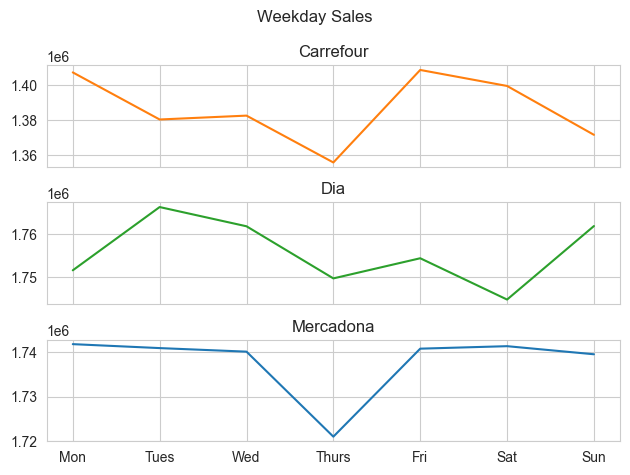

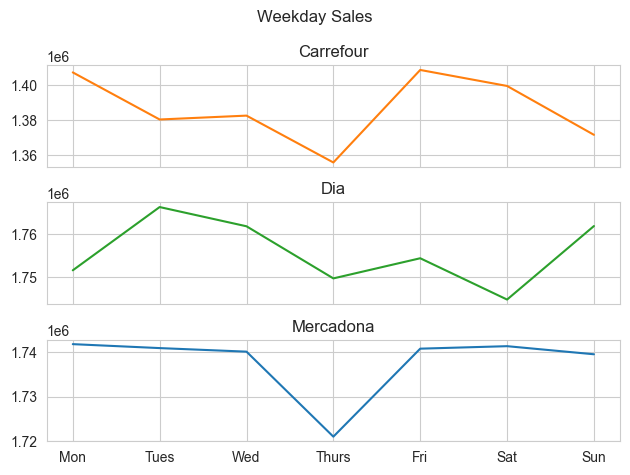

In [173]:
fig, axs= plt.subplots(3, sharex=True)
fig.suptitle('Weekday Sales')
x = by_weekday.index
axs[0].plot(x, by_weekday['Carrefour sales'], 'tab:orange')
axs[0].set_title('Carrefour')
axs[1].plot(x, by_weekday['Dia sales'],'tab:green')
axs[1].set_title('Dia')
axs[2].plot(x, by_weekday['Mercadona sales'])
axs[2].set_title('Mercadona')
fig.tight_layout();

monthly sales

In [174]:
monthlyCarre = raw_data_carre['price'].resample('M').sum()
monthlyDia = raw_data_dia['price'].resample('M').sum()
monthlyMerca = raw_data_merca['price'].resample('M').sum()
monthlyCarre

daily_sales
2021-03-31    962430.48
2021-04-30    432966.71
2021-05-31    367525.73
2021-06-30    364404.03
2021-07-31    381906.89
2021-08-31    366186.24
2021-09-30    365166.30
2021-10-31    399537.17
2021-11-30    460273.76
2021-12-31    469766.81
2022-01-31    479942.78
2022-02-28    446416.91
2022-03-31    443549.21
2022-04-30    440755.48
2022-05-31    460335.95
2022-06-30    475760.20
2022-07-31    488832.13
2022-08-31    476266.42
2022-09-30    469919.77
2022-10-31    458035.06
2022-11-30    495209.59
Freq: M, Name: price, dtype: float64

daily_sales
2021-03-31    962430.48
2021-04-30    432966.71
2021-05-31    367525.73
2021-06-30    364404.03
2021-07-31    381906.89
2021-08-31    366186.24
2021-09-30    365166.30
2021-10-31    399537.17
2021-11-30    460273.76
2021-12-31    469766.81
2022-01-31    479942.78
2022-02-28    446416.91
2022-03-31    443549.21
2022-04-30    440755.48
2022-05-31    460335.95
2022-06-30    475760.20
2022-07-31    488832.13
2022-08-31    476266.42
2022-09-30    469919.77
2022-10-31    458035.06
2022-11-30    495209.59
Freq: M, Name: price, dtype: float64

In [175]:
monthlyComparatives = pd.concat([monthlyCarre,monthlyDia,monthlyMerca], join='inner', axis=1)
monthlyComparatives.columns =['Carrefour sales', 'Dia sales', 'Mercadona sales']
monthlyComparatives = monthlyComparatives.rename_axis('monthly_sales')
monthlyComparatives

,Carrefour sales,Dia sales,Mercadona sales
monthly_sales,,,
2021-03-31,962430.48,673134.65,524837.24
2021-04-30,432966.71,615512.44,579816.26
2021-05-31,367525.73,617279.81,603101.06
2021-06-30,364404.03,590204.90,585391.99
2021-07-31,381906.89,599631.72,604384.10
2021-08-31,366186.24,519391.37,598523.70
2021-09-30,365166.30,455585.41,569412.06
2021-10-31,399537.17,485402.51,585276.54
2021-11-30,460273.76,589922.41,581745.56


,Carrefour sales,Dia sales,Mercadona sales
monthly_sales,,,
2021-03-31,962430.48,673134.65,524837.24
2021-04-30,432966.71,615512.44,579816.26
2021-05-31,367525.73,617279.81,603101.06
2021-06-30,364404.03,590204.90,585391.99
2021-07-31,381906.89,599631.72,604384.10
2021-08-31,366186.24,519391.37,598523.70
2021-09-30,365166.30,455585.41,569412.06
2021-10-31,399537.17,485402.51,585276.54
2021-11-30,460273.76,589922.41,581745.56


<Figure size 5000x1000 with 0 Axes>

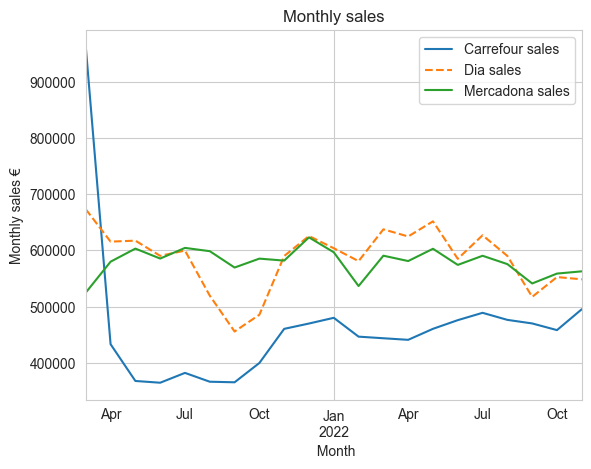

<Figure size 5000x1000 with 0 Axes>

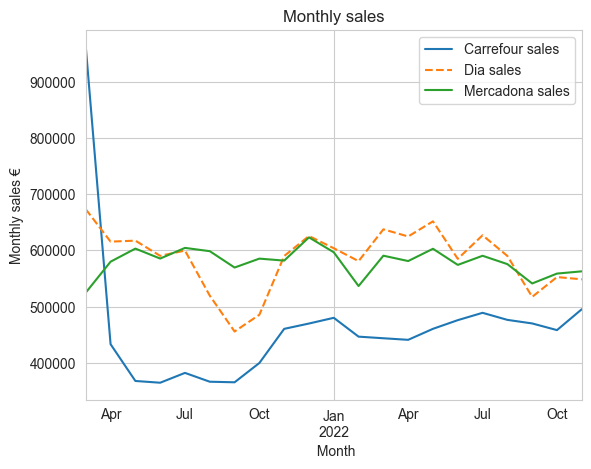

In [176]:
plt.figure(figsize=(50,10))
monthlyComparatives.plot(style=["-", '--', '-'])
plt.title("Monthly sales")
plt.legend
plt.xlabel(" Month")
plt.ylabel("Monthly sales €");

## 5. Modeling:
Mercadona's sales volume model. The model would require more data, nevertheless, Let's try!

In [177]:
rmodelMerca.head()

,name,price,daily_sales,unit
5014,Lavavajillas frescor anti-olor Somat en gel,4.85,2021-03-05,1
5015,Detergente ropa blanca y de color Bosque Verde...,3.30,2021-03-05,1
5016,Detergente ropa jabón de Marsella Bosque Verde...,4.20,2021-03-05,1
5017,Detergente ropa poder dúo Bosque Verde en cáps...,3.30,2021-03-05,1
5018,Detergente ropa All in 1 Ariel en cápsulas,3.30,2021-03-05,1


,name,price,daily_sales,unit
5014,Lavavajillas frescor anti-olor Somat en gel,4.85,2021-03-05,1
5015,Detergente ropa blanca y de color Bosque Verde...,3.30,2021-03-05,1
5016,Detergente ropa jabón de Marsella Bosque Verde...,4.20,2021-03-05,1
5017,Detergente ropa poder dúo Bosque Verde en cáps...,3.30,2021-03-05,1
5018,Detergente ropa All in 1 Ariel en cápsulas,3.30,2021-03-05,1


In [178]:
#no nans
rmodelMerca.isnull().sum()

name           0
price          0
daily_sales    0
unit           0
dtype: int64

name           0
price          0
daily_sales    0
unit           0
dtype: int64

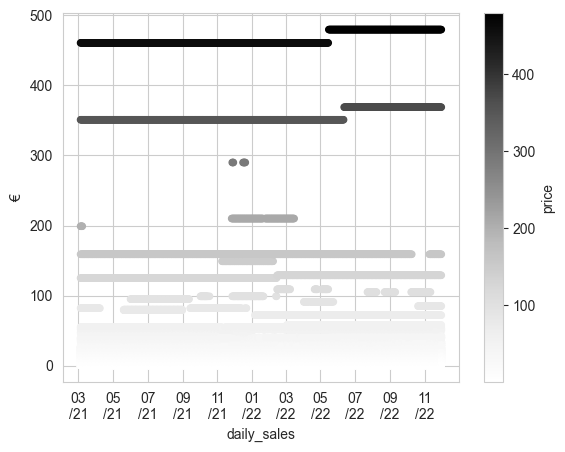

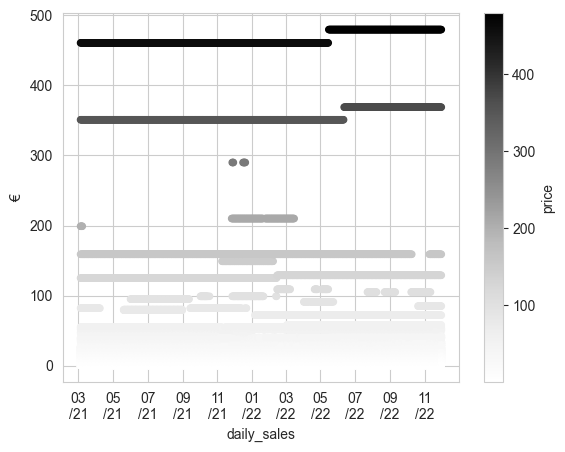

In [179]:
#outliers?
import matplotlib.dates as mdates

ax = rmodelMerca.plot(kind='scatter', x='daily_sales', y='price', c='price')
myFmt = mdates.DateFormatter('%m\n/%y')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel("€")
plt.show()

In [180]:
modelMerca2 = rmodelMerca.copy()


In [181]:
modelMerca2 = modelMerca2.groupby(['daily_sales','name']).sum()
modelMerca2['price*unit'] = modelMerca2['price']*modelMerca2['unit']
modelMerca2

price  unit  price*unit
daily_sales name                                                            
2021-03-05  1/4 Sandía                                2.60     1        2.60
            11 Panecillos                             1.00     1        1.00
            2 Baguettes para hornear Hacendado        0.75     1        0.75
            3 Baguettes masa madre                    1.15     1        1.15
            3 Barras de pan                           1.10     1        1.10
...                                                    ...   ...         ...
2022-11-30  Zumo fresh jengibre & manzana Hacendado   1.60     1        1.60
            Zumo fresh maracuyá & chía Hacendado      2.75     1        2.75
            Zumo pura naranja Hacendado               3.05     2        6.10
            Zumo pura naranja con pulpa Hacendado     1.05     1        1.05
            Ñoras Hacendado                           1.40     1        1.40

[3410436 rows x 3 columns]

price  unit  price*unit
daily_sales name                                                            
2021-03-05  1/4 Sandía                                2.60     1        2.60
            11 Panecillos                             1.00     1        1.00
            2 Baguettes para hornear Hacendado        0.75     1        0.75
            3 Baguettes masa madre                    1.15     1        1.15
            3 Barras de pan                           1.10     1        1.10
...                                                    ...   ...         ...
2022-11-30  Zumo fresh jengibre & manzana Hacendado   1.60     1        1.60
            Zumo fresh maracuyá & chía Hacendado      2.75     1        2.75
            Zumo pura naranja Hacendado               3.05     2        6.10
            Zumo pura naranja con pulpa Hacendado     1.05     1        1.05
            Ñoras Hacendado                           1.40     1        1.40

[3410436 rows x 3 columns]

In [182]:
modelMerca2 = modelMerca2.groupby(['daily_sales']).sum()

In [183]:
modelMerca2 = modelMerca2.drop(['price','unit'], axis=1)

In [184]:
modelMerca2.columns = ['Sales_volume']

In [185]:
trainMerca = modelMerca2.copy()
trainMerca.to_excel('./data:processed/processed_data.xlsx')
